## State
Subgrafos permitem criar e gerenciar diferentes estados em diferentes partes do seu grafo.

Isso é particularmente útil para sistemas multiagentes, com equipes de agentes, cada um com seu próprio estado.

Vamos considerar um exemplo simples:

Tenho um sistema que aceita logs.
Ele executa duas subtarefas separadas por agentes diferentes (resumir logs, encontrar modos de falha).
Quero executar essas duas operações em dois subgrafos diferentes.

O mais importante é entender como os grafos se comunicam!

Resumidamente, a comunicação é feita com chaves sobrepostas:

Os subgrafos podem acessar os documentos do grafo pai.
O grafo pai pode acessar o resumo/relatório de falhas dos subgrafos.


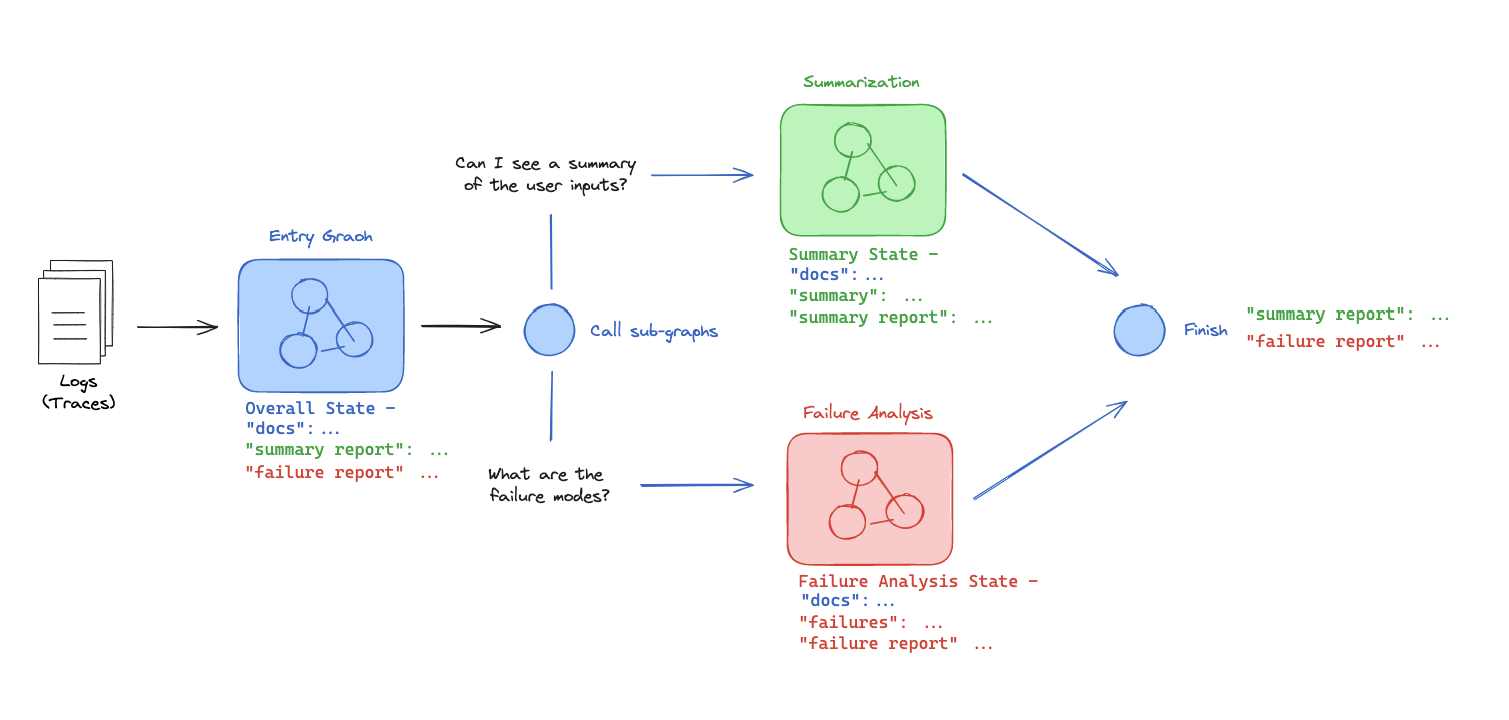

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

### Sub graphs
Aqui está o subgráfico de análise de falhas, que utiliza FailureAnalysisState.

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Adicionando subgrafos ao nosso grafo principal
Agora, podemos juntar tudo.

Criamos nosso grafo principal com EntryGraphState.

E adicionamos nossos subgrafos como nós

`entry_builder.add_node("question_summarization", qs_builder.compile())`

`entry_builder.add_node("failure_analysis", fa_builder.compile())`

In [ ]:

# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

Mas, por que `cleaned_logs` possui um reducer se ele apenas entra em cada subgrafo como entrada? Ele não é modificado.

`cleaned_logs: Annotated[List[Log], add]` # Isso será USADO POR AMBOS os subgrafos
Isso ocorre porque o estado de saída dos subgrafos conterá todas as chaves, mesmo que elas não sejam modificadas.

Os subgrafos são executados em paralelo.

Como os subgrafos paralelos retornam a mesma chave, é necessário um reducer como `operator.add` para combinar os valores recebidos de cada subgrafo.

Mas podemos contornar isso usando outro conceito que discutimos anteriormente.

Podemos simplesmente criar um esquema de estado de saída para cada subgrafo e garantir que o esquema de estado de saída contenha chaves diferentes para publicar como saída.

Na verdade, não precisamos que cada subgrafo gere `cleaned_logs` como saída.

In [ ]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

O modelo de estado no LangGraph (e na maioria dos sistemas de grafos aninhados) funciona de forma a garantir que as modificações internas em um subgrafo não vazem ou atualizem o estado do grafo pai até que o subgrafo retorne o seu resultado final.

🏗️ Funcionamento do Estado em Subgrafos
Em um grafo aninhado (onde um nó do grafo principal é um subgrafo, como um CompiledGraph), o LangGraph trata o subgrafo como uma função atômica em relação ao grafo pai:

1. Isolamento Interno (Modificações Não Vazam)
Quando o grafo pai invoca o subgrafo, ele fornece uma cópia do seu estado inicial (incluindo o par chave-valor compartilhado).

Quaisquer modificações que ocorram nesse par chave-valor dentro dos nós do subgrafo (durante a execução intermediária) são salvas apenas no estado interno do subgrafo.

O grafo pai não é notificado dessas alterações intermediárias.

2. Sincronização Final (Retorno)
A única vez que o grafo pai recebe as atualizações é quando o subgrafo atinge seu ponto final (END) e retorna o seu estado modificado.

O LangGraph, então, pega o estado de retorno do subgrafo e o mescla com o estado do grafo pai, atualizando o par chave-valor compartilhado com o valor final gerado pelo subgrafo.

3. Independência de Subgrafos
Se você tem dois subgrafos (Subgrafo A e Subgrafo B) que usam a mesma chave-valor do grafo pai:

As modificações que ocorrem dentro do Subgrafo A não são visíveis imediatamente para o Subgrafo B.

O Subgrafo B só verá o valor atualizado se ele for executado após o Subgrafo A ter terminado sua execução e o grafo pai ter sincronizado o estado.

Isso garante que o controle de fluxo seja previsível e que as modificações de estado de uma seção do grafo não criem efeitos colaterais inesperados em outra seção enquanto ainda estão em execução.